Analyze the progression of the frontier points algorithm with temperature change


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append('/Users/zofia/github/DFM/srcDiffmap')

import mdtraj as md

import integrator
import sampler #as sampler
import model #as model
import diffusionmap as dm
import statistics_dfm as stat

import numpy as np
from simtk import openmm, unit
from openmmtools.constants import kB

import model
mdl=model.Model('Alanine')
mdlTopology=mdl.testsystem.topology
print (mdl.x_unit)
print('System has %d particle(s)' % mdl.system.getNumParticles())
print (mdl.testsystem.positions)
X0=mdl.testsystem.positions.value_in_unit(mdl.x_unit)
print('Initial distance is %f' % np.linalg.norm(X0[0,:]-X0[ 1,:]))

algoVect=0

# parameters
# this is the target temperature 
T=300.0
temperature =  T * unit.kelvin#300 * unit.kelvin
kT = kB * temperature


gamma = 1.0 / unit.picosecond
dt = 2.0 * unit.femtosecond

TemperatureTAMDFactor=30.0
massScale=50.0

gammaScale=100.0
kappaScale=1000.0

print("TemperatureTAMDFactor = " + repr(TemperatureTAMDFactor))
temperatureAlpha= (T*TemperatureTAMDFactor)* unit.kelvin

print('Gamma is '+repr(gamma))
print('Temperature is '+repr(temperature))
print('Temperature TAMD '+repr(TemperatureTAMDFactor)+'xTemperature')
print('Mass alpha is '+repr(massScale)+'x Mass')



# simulation class sampler takes integrator class with chosen parameters as input
integrator=integrator.Integrator( model=mdl, gamma=gamma, temperature=temperature, temperatureAlpha=temperatureAlpha, dt=dt, massScale=massScale, gammaScale=gammaScale, kappaScale=kappaScale)
samplerAlgo=sampler.Sampler(model=mdl, integrator=integrator, algorithm=0, dataFileName='Data')

# nrSteps is number of steps for each nrRep , and iterate the algo nrIterations times - total simulation time is nrSteps x nrIterations
# nrSteps=args.nrSteps
# nrEquilSteps = 10 #10000
# nrIterations=args.niterations
# nrRep=args.nreplicas

algoNames=samplerAlgo.algorithmName

simulatedTemperature=300

print(samplerAlgo.model.testsystem.topology)

In [79]:
methodName =  'corner_temperature_change_off'#'corner_temperature_change_off'#'frontier_points_corner'
dataName='TemporaryData'

numberOfIterations=10

import pyemma.coordinates as coor
#print samplerAlgo[0].model.testsystem.topology
feat = coor.featurizer(md.Topology().from_openmm(samplerAlgo.model.testsystem.topology))
#print traj[0]

#feat.add_dihedrals(np.asarray([[6, 8, 14, 16], [4, 6, 8, 14]]))
feat.add_backbone_torsions()

# traj[0].unitcell_lengths=np.zeros((traj[0].xyz.shape[0],traj[0].xyz.shape[2]))
# traj[0].unitcell_angles=traj[0].unitcell_lengths
#print('/Users/zofia/github/DFM/Data/frontier_points_corner/Traj/Alaninetraj_'+repr(i)+'.h5')

#inp=[coor.load('/Users/zofia/github/DFM/Data/Alanine/std/Traj/Alaninetraj_'+repr(i)+'.h5', feat) for i in range(numberOfIterations) ] 
inp=[coor.load('/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/Alaninetraj_'+repr(i)+'.h5', feat) for i in range(numberOfIterations) ] 
#
print( np.asarray(inp).shape)

#inp = [coor.source(traj[ia].xyz, feat) for ia in range(0,len(algoVect))]
#print('number of trajectories = ',inp.number_of_trajectories())
#print('trajectory length = ',inp.trajectory_length(0))
#print('trajectory time step = ',500.0 / (inp.trajectory_length(0)-1),'ns')
#print('number of dimension = ',inp.dimension())

#print(inp)




 



(10, 5000, 2)


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


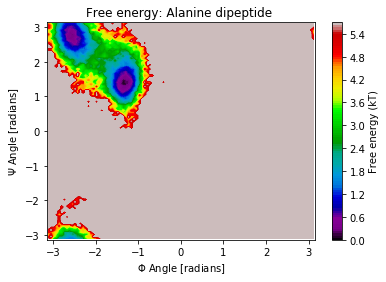

In [80]:

import pyemma.plots as mplt
from math import pi


   
Y = inp   
   
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
plt.savefig('/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/freeEnergy.png', dpi='figure', bbox_inches='tight')


plt.show()

    

In [81]:
#'/Users/zofia/github/DFM/Data/Std/Traj/*.h5'


#---------------- load trajectories: for example from simulation at higher temperature
import glob



def loadData(fileName, iteration=False):
    print('Loading data from '+ fileName)
    numpy_vars = []
    
    print(fileName+'*.h5')
    if iteration== False:
        
        for np_name in glob.glob(fileName+'*.h5'):
            numpy_vars.append(md.load(np_name))
    else:
        for np_name in glob.glob(fileName):
            numpy_vars.append(md.load(np_name))

    traj = numpy_vars
    print(len(traj))

    Xmdtraj=list()
    for i in range(len(traj)):
        #print(traj[i][0].xyz)
        Xmdtraj.append(md.Trajectory(traj[i].xyz, samplerAlgo.model.testsystem.topology))#mdl.testsystem.topology) )

    print(Xmdtraj[0].xyz.shape[2])
    L=int(Xmdtraj[0].xyz.shape[0]*len(traj))
    nrP=int(Xmdtraj[0].xyz.shape[1])
    print(nrP)
    D=int(Xmdtraj[0].xyz.shape[2])
    X=np.zeros((L, nrP, D))
    for i in range(0,len(Xmdtraj)):
            X[i*len(Xmdtraj[i].xyz):(i+1)*len(Xmdtraj[i].xyz),:,:]=Xmdtraj[i].xyz
    
    Xmdtraj = md.Trajectory(X, mdlTopology )
    
    return X, traj, Xmdtraj


In [82]:

#nameData = '/Users/zofia/github/DFM/Data/frontier_points_change_temperature/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/frontier_points/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/Alanine/std/Traj/'
nameData = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/'



X_FT, traj_FT, Xmdtraj_FT = loadData(nameData)


Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/*.h5
10
3
22


In [83]:
# #print(Xmdtraj_FT[0].xyz)
# def computeRMSD(Xmdtraj_FT):
#     rmsd=np.zeros(len(Xmdtraj_FT))
#     for i in range(len(Xmdtraj_FT)):
#         rmsd[i]= md.rmsd(Xmdtraj_FT[0], Xmdtraj_FT[i])
#     #print(rmsd)
#     return rmsd

# rmsd=computeRMSD(Xmdtraj_FT)
# plt.plot(range(len(rmsd)),rmsd)
# plt.legend(['RMSD'])


# plt.show()



In [84]:
# load saved frontier points 


#nameData = '/Users/zofia/github/DFM/Data/frontier_points_change_temperature/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/frontier_points/Traj/'
#nameData = '/Users/zofia/github/DFM/Data/Alanine/std/Traj/'
nameDataFrontier = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/FrontierPoints/'


X_frontier, bla, Xmd_frontier = loadData(nameDataFrontier)

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/*.h5
10
3
22


In [85]:
#plot sampled trajctories
def plotSamplingDihedrals(nameData, nameFrontier, samplerAlgo, singleDataFrame=False):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if singleDataFrame==True:
        for i in range(len(nameData)):
        
            X_FT, bla, Xmd_FT = loadData(nameData[i], iteration=True)
            
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');
            
    
    else:
            X_FT, bla, Xmd_FT = loadData(nameData)
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');

    #load frontier points
    if singleDataFrame==True:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier, iteration=True)
    else:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
            
    plt.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], c='r');
    
    plt.title('Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    
    
    plt.savefig('/Users/zofia/github/DFM/'+dataName+'/Alanine/dihedrals'+methodName+'.png',  format='png', dpi=1000, bbox_inches='tight')
    plt.show()
    
    Y = angles   
   
    mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
    plt.show()
   

#plot sampled trajectories
def plotSamplingDihedralsEigenvectors(nameData, nameFrontier, nameEigenvector, samplerAlgo, singleDataFrame=False):
    
    psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
    top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
    if singleDataFrame==True:
        
        
            X_FT, bla, Xmd_FT = loadData(nameData, iteration=True)
            
            inp=md.Trajectory(X_FT, top)
            
            FEV=np.load(nameEigenvector)
            V1=FEV[:,0]

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            print(V1.shape)
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c=V1);
            plt.colorbar()
           
            
            
    
    else:
            X_FT, bla, Xmd_FT = loadData(nameData)
            inp=md.Trajectory(X_FT, top)

            angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
            plt.scatter(angles[:, 0], angles[:, 1], s=5, c='b');

    #load frontier points
    if singleDataFrame==True:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier, iteration=True)
    else:
            
            X_frontier, bla, Xmd_frontier = loadData(nameFrontier)
    inpFrontierPoints = md.Trajectory(X_frontier, top)
    anglesFrontierPoints = md.geometry.compute_dihedrals(inpFrontierPoints, [phi_indices, psi_indices]) 
            
    plt.scatter(anglesFrontierPoints[:, 0], anglesFrontierPoints[:, 1], c='r');
    
    plt.title('Alanine dipeptide ')
    plt.xlabel(r'$\Phi$ Angle [radians]')
    plt.xlim(-pi, pi)
    plt.ylabel(r'$\Psi$ Angle [radians]')
    plt.ylim(-pi, pi)
    
    
    plt.savefig('/Users/zofia/github/DFM/'+dataName+'/Alanine/dihedrals_eigenvectors'+methodName+'.png',  format='png', dpi=1000, bbox_inches='tight')
    plt.show()

corner_temperature_change_off
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_0.h5*.h5
1
3
22
(1250,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5*.h5
1
3
22


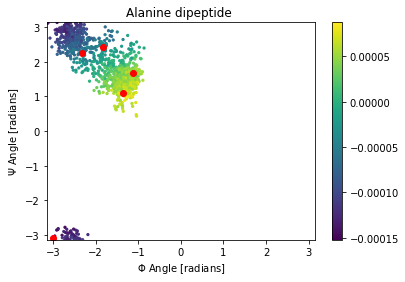

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_1.h5*.h5
1
3
22
(1250,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5*.h5
1
3
22


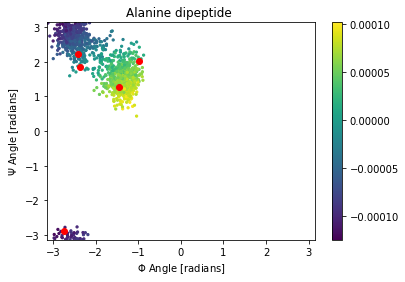

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_2.h5*.h5
1
3
22
(1875,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5*.h5
1
3
22


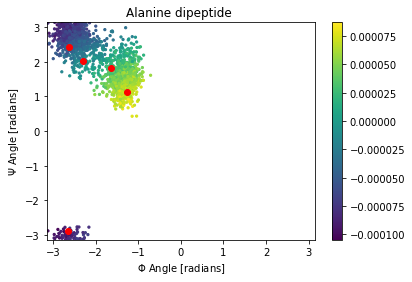

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_3.h5*.h5
1
3
22
(1250,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_3.h5*.h5
1
3
22


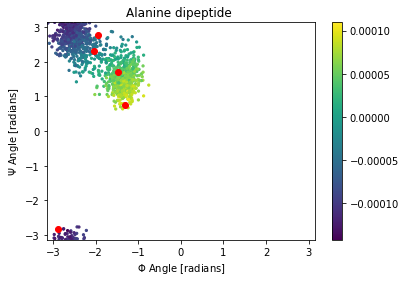

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_4.h5*.h5
1
3
22
(1563,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_4.h5*.h5
1
3
22


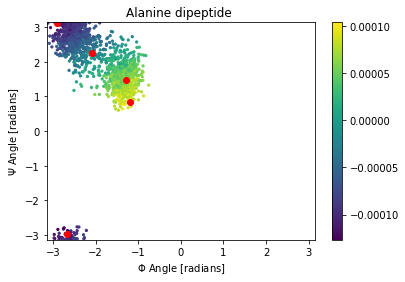

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_5.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_5.h5*.h5
1
3
22
(1875,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_5.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_5.h5*.h5
1
3
22


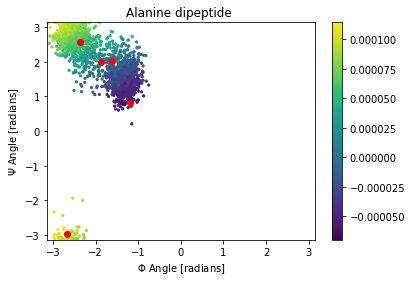

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_6.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_6.h5*.h5
1
3
22
(1094,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_6.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_6.h5*.h5
1
3
22


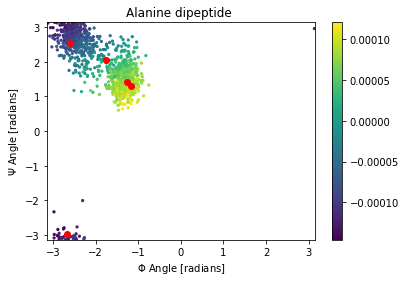

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_7.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_7.h5*.h5
1
3
22
(1250,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_7.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_7.h5*.h5
1
3
22


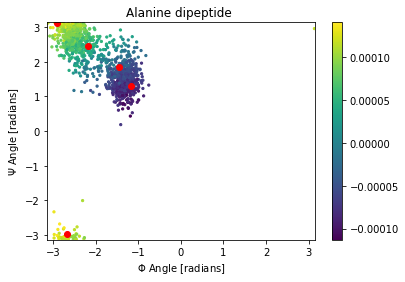

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_8.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_8.h5*.h5
1
3
22
(1407,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_8.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_8.h5*.h5
1
3
22


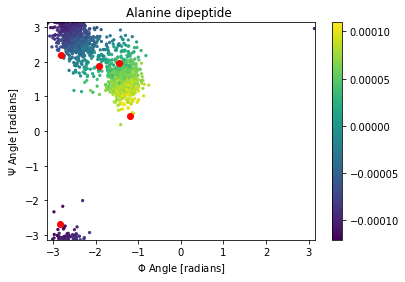

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_9.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/Eigenvectors/traj_9.h5*.h5
1
3
22
(1563,)
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_9.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/frontierPoints_at_iteration_9.h5*.h5
1
3
22


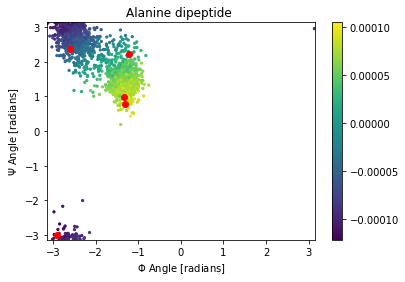

In [86]:
nameData_i_list=list()

print(methodName)
for i in range(numberOfIterations):
    
    nameData_i = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/Eigenvectors/traj_'+repr(i)+'.h5'
    nameDataEigenvector_i = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/Eigenvectors/V1_'+repr(i)+'.npy'
    nameDataFrontier_i = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/FrontierPoints/frontierPoints_at_iteration_'+repr(i)+'.h5'
    plotSamplingDihedralsEigenvectors(nameData_i, nameDataFrontier_i, nameDataEigenvector_i, samplerAlgo, singleDataFrame=True)

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_0.h5*.h5
1
3
22


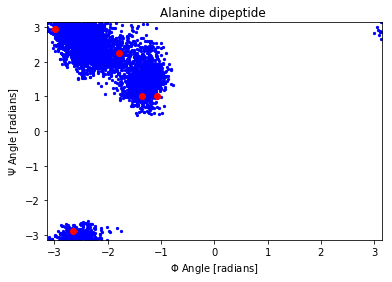

/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


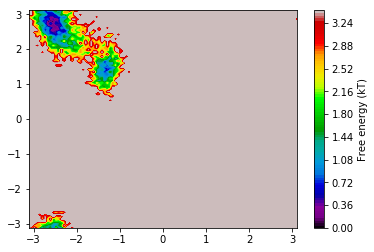

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_1.h5*.h5
1
3
22


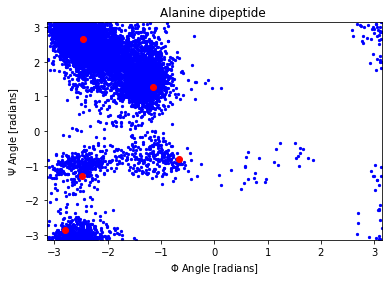

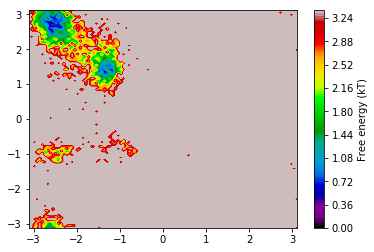

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_2.h5*.h5
1
3
22


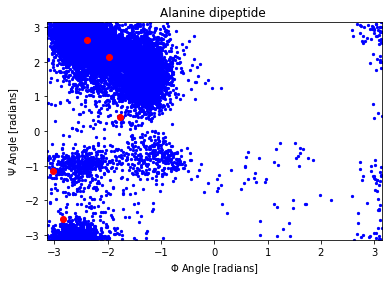

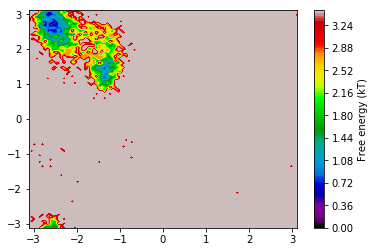

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/FrontierPoints/frontierPoints_at_iteration_3.h5
/Users/zofia/git

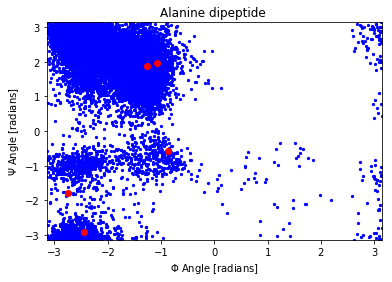

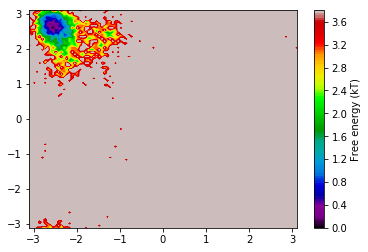

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

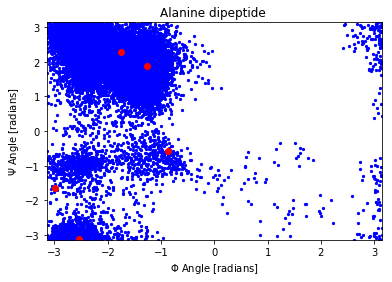

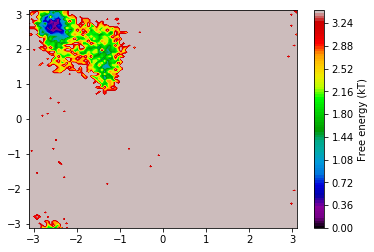

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

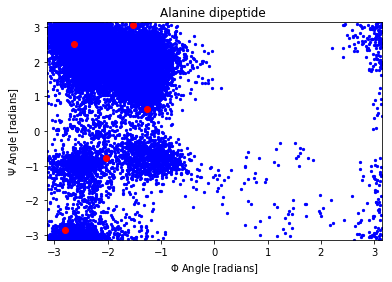

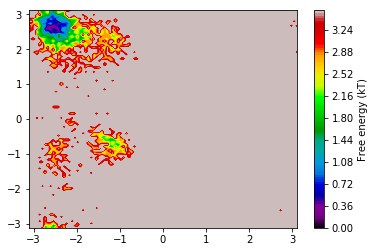

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

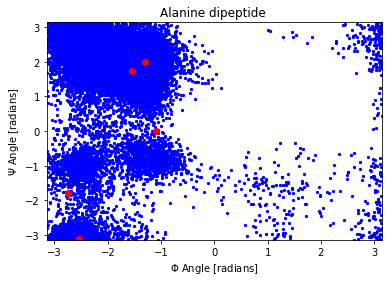

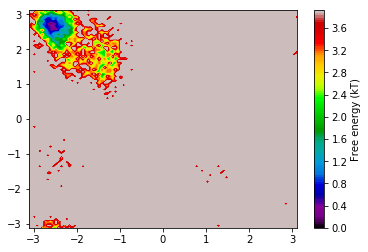

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

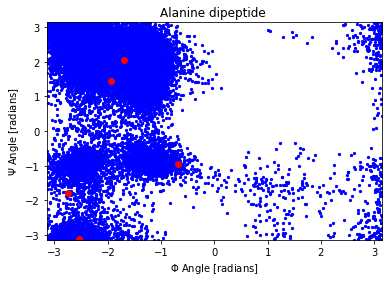

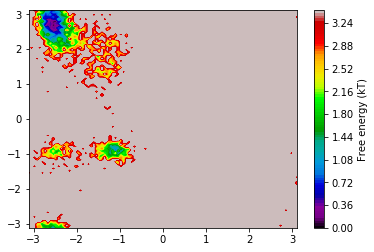

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

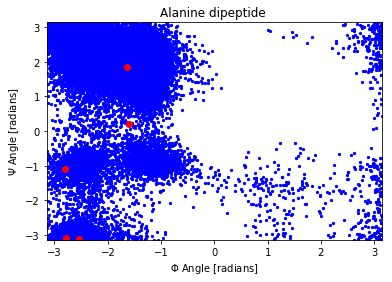

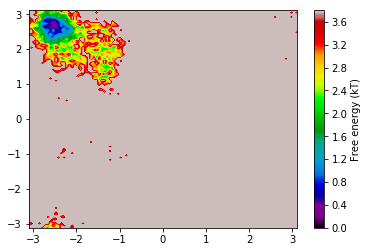

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_0.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_1.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_2.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_3.h5*.h5
1
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/frontier_points_corner/Traj/Alaninetraj_4.h5
/Users/zofia/github/DFM/TemporaryData/Alanine/f

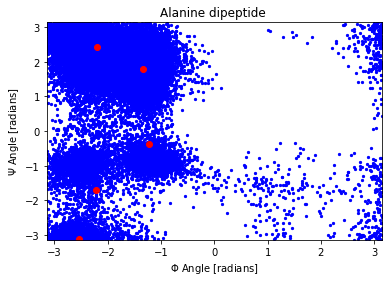

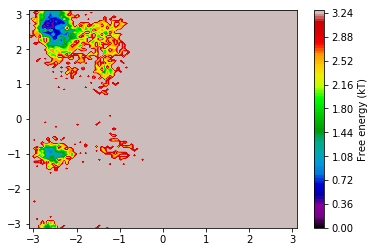

In [77]:
nameData_i_list=list()
for i in range(numberOfIterations):
    
    nameData_i = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/Alaninetraj_'+repr(i)+'.h5'
    nameDataFrontier_i = '/Users/zofia/github/DFM/'+dataName+'/Alanine/'+methodName+'/Traj/FrontierPoints/frontierPoints_at_iteration_'+repr(i)+'.h5'
    nameData_i_list.append(nameData_i)
    plotSamplingDihedrals(nameData_i_list, nameDataFrontier_i, samplerAlgo, singleDataFrame=True)

Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/*.h5
10
3
22
Loading data from /Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/
/Users/zofia/github/DFM/TemporaryData/Alanine/corner_temperature_change_off/Traj/FrontierPoints/*.h5
10
3
22


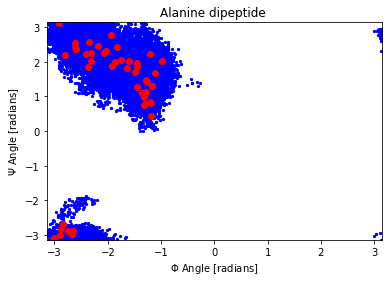

/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


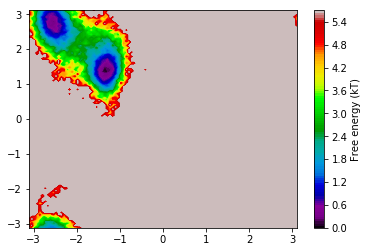

In [87]:
plotSamplingDihedrals(nameData, nameDataFrontier, samplerAlgo)

In [ ]:
import imp
imp.reload(sampler)
imp.reload(dm)
imp.reload(stat)

def getDominantEigenvector(tr, eps, numberOfLandmarks, smpl, model, T, method): 
        
        tr_orig=tr
        
        tmp=md.Trajectory(tr, model.testsystem.topology)
        tmp = tmp.superpose(tmp[0])
        #------ reshape data ------------------------------

        tmp =  tmp.xyz.reshape((tmp.xyz.shape[0], tmp.xyz.shape[1]*tmp.xyz.shape[2]))
                
        tr=tmp
        FEV, qTarget, qEmp, Epot, kernel=sampler.dominantEigenvectorDiffusionMap(tr, eps, smpl, T, method, nrOfFirstEigenVectors=3)
        
        print(FEV.shape)
        v1=FEV[:,0]
        #qTargetNormalized = qTarget/np.sum(qTarget)
        
        #get landmarks
        lm, levelsets, linspV = dm.get_landmarks(tr, numberOfLandmarks, qTarget, v1, Epot, getLevelSets=True)
        
        levelsets, levels = dm.get_levelsets(tr, numberOfLandmarks, qTarget, v1);
        
        tr =  tr.reshape((tr_orig.shape[0], tr_orig.shape[1],tr_orig.shape[2]))
        
        return tr, levelsets, FEV, lm, qEmp, Epot, qTarget


def computeFreeEnergyAtLandmarkedPoint(qTarget, qEmp, levelsets, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
        K=len(levelsets)
        
        freeEnergy=np.zeros(K)
        h=np.zeros(K)

        for k in range(0,K):
            # simple histogram
            if(method == 'raw'):
                h[k] = np.sum(len(levelsets[k]))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelsets[k]])
            
        for k in range(0,K):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'raw'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] =  -np.log( h[k]/sum(h) / Ntilde)
                
                
        
                
        if(method=='weighted'):
            return freeEnergy, weight, Ntilde
        else:
            return freeEnergy

        
def computeFreeEnergyAtEveryPoint(X, V1, width, qTarget, qEmp, method='weighted'):
      
        if(method=='weighted'):
            weight, Ntilde = stat.compute_weight_target_distribution(qTarget, qEmp)
        
        
     
        freeEnergy=np.zeros(len(X))
        h=np.zeros(len(X))

        for k in range(0,len(X)):
            
            levelset = dm.get_levelset_onePoint(k, width, V1)
            #print(len(levelset))
            
            # simple histogram
            if(method == 'raw'):
                h[k] = np.sum(len(levelset))
            elif(method=='weighted'):
#              # unbiased histogram- we can use weights!!
                h[k] = np.sum(weight[levelset])
    
            
        for k in range(0,len(X)):
            if(h[k] == 0):
                freeEnergy[k] = 0 # if the bin is empty set 0
            else:
                if(method == 'raw'):
                    freeEnergy[k] = -np.log(h[k]/sum(h))
                elif(method=='weighted'):
#              
                    freeEnergy[k] =  -np.log( h[k]/ Ntilde)
                
                
        
                
        if(method=='weighted'):
            return freeEnergy#, weight, Ntilde
        else:
            return freeEnergy

#

In [ ]:
numberOfLandmarks=10
epsilon=1

Xshort=X_FT
print(len(Xshort))
while(len(Xshort)>10000):
    Xshort=Xshort[::2]
#Xshort=X[::10]
print("Shape of input data: "+repr((Xshort.shape)))

# # note that samplerAlgo.T gives the target temperature from the at the beginning initialized class
# print("Target temperature is "+repr(samplerAlgo.T))



#freeEnergy_FT, weight_FT, Ntilde_FT = computeFreeEnergyAtLandmarkedPoint(qTarget_FT, qEmp_FT, levelsets_FT, method='weighted')


In [ ]:
# compute diffusion maps 
#Xsp_FT,levelsets_FT, FEV, lm_FT, qEmp_FT, Epot_FT, qTarget_FT =getDominantEigenvector(Xshort, epsilon, numberOfLandmarks, samplerAlgo, samplerAlgo.model, samplerAlgo.T, 'TMDiffmap')#'TMDiffmap')#'Diffmap')



In [41]:
tmp=FEV

print(FEV.shape)
V1_FT=tmp[:,0]
V2_FT=tmp[:,1]
results = [Xsp_FT,levelsets_FT, FEV, lm_FT, qEmp_FT, Epot_FT, qTarget_FT]
#np.save('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/results_6250_64kNN.npy', results)


(6250, 2)


In [42]:
[Xsp_FT,levelsets_FT, FEV, lm_FT, qEmp_FT, Epot_FT, qTarget_FT]=np.load('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/results_6250.npy')
#V1_FT = FEV[:,0]

In [43]:
width=0.1
freeEnergy = computeFreeEnergyAtEveryPoint(Xsp_FT, V1_FT, width, qTarget_FT, qEmp_FT, method='weighted')
#print(freeEnergy)
#print(samplerAlgo.T)

(6250, 22, 3)


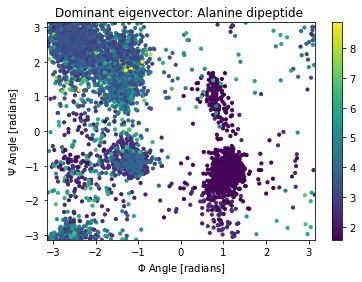

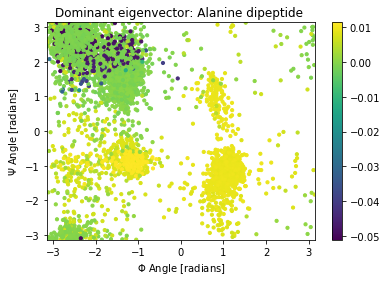

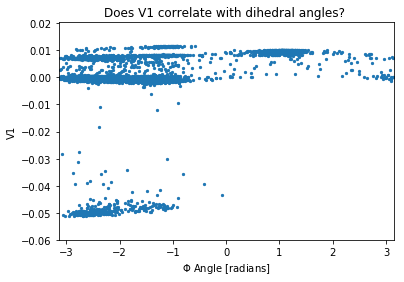

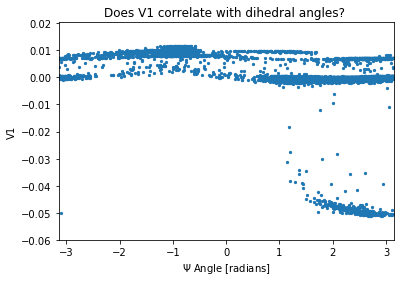

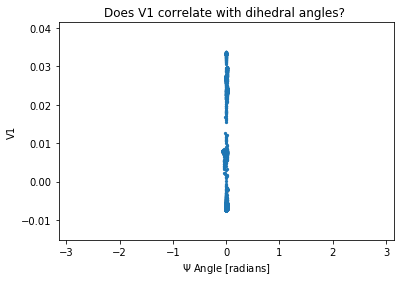

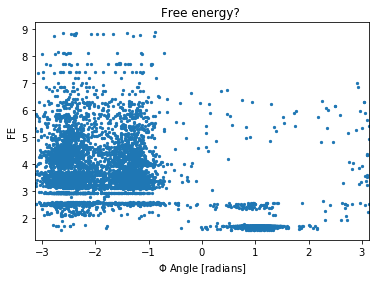

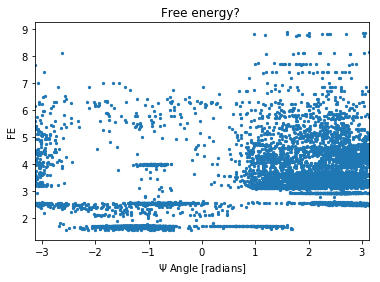

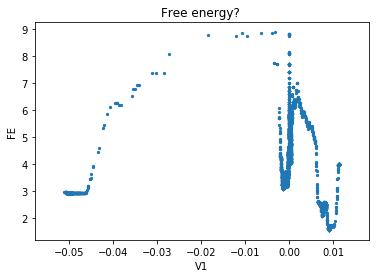

In [44]:
top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
inpShort=md.Trajectory(Xsp_FT, top)

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
angles = md.geometry.compute_dihedrals(inpShort, [phi_indices, psi_indices]) 


print((Xsp_FT.shape))
plt.scatter(angles[:, 0], angles[:, 1], c=freeEnergy, s=10);#, c=V1_FT);
plt.title('Dominant eigenvector: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.colorbar()
plt.show()

plt.scatter(angles[:, 0], angles[:, 1], c=V1_FT, s=10);#, c=V1_FT);
plt.title('Dominant eigenvector: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.colorbar()
plt.show()



plt.scatter(angles[:, 0], V1_FT, s=5);
plt.title('Does V1 correlate with dihedral angles? ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('V1')

plt.show()

plt.scatter(angles[:, 1], V1_FT, s=5);
plt.title('Does V1 correlate with dihedral angles? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('V1')

plt.show()


plt.scatter(V1_FT, V2_FT, s=5);
plt.title('Does V1 correlate with dihedral angles? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('V1')

plt.show()

plt.scatter(angles[:, 0], freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('FE')

plt.show()

plt.scatter(angles[:, 1], freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel('FE')

plt.show()

plt.scatter(V1_FT, freeEnergy, s=5);
plt.title('Free energy? ')
plt.xlabel(r'$\Psi$ Angle [radians]')
plt.xlabel(r'V1')

plt.ylabel('FE')

plt.show()

In [30]:
# Averages
imp.reload(stat)
imp.reload(dm)
#print(samplerAlgo.model.energy)
#print(weight)



weight, Ntilde = stat.compute_weight_target_distribution(qTarget_FT, qEmp_FT)
print('mean weight is '+repr(np.mean(weight)))

#-----------average energy
meanV = stat.computeAverages(Xsp_FT, samplerAlgo.model.energy, units=samplerAlgo.model.energy_unit)
meanVunbiased = stat.computeUnbiasedAverages(Xsp_FT, samplerAlgo.model.energy, weight, units=samplerAlgo.model.energy_unit)

print('Raw:')
print('<V> = '+repr(meanV*samplerAlgo.model.energy_unit))

print('\nUnbiased:')
print('<V> = '+repr(meanVunbiased*samplerAlgo.model.energy_unit))


#---------- average rmsd

# #give the rmsd vector
# rmsdShort=computeRMSD(inpShort)

# meanR = stat.computeAverages(Xshort, rmsdShort, vectorFunction=True)
# meanRunbiased = stat.computeUnbiasedAverages(Xshort, rmsdShort, weight, vectorFunction=True)

# print('Raw:')
# print('<rmsd> = '+repr(meanR*samplerAlgo.model.x_unit))

# print('\nUnbiased:')
# print('<rmsd> = '+repr(meanRunbiased*samplerAlgo.model.x_unit))




mean weight is 0.016254673722134259
Raw:
<V> = Quantity(value=-5.6457248716568955, unit=kilojoule/mole)

Unbiased:
<V> = Quantity(value=3.0956440495321171, unit=kilojoule/mole)


In [31]:
print(np.sum(weight))

101.591710763


/Users/zofia/miniconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


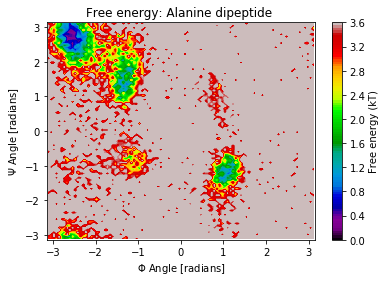

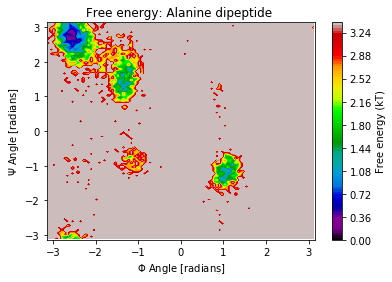

In [32]:

   
psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
            
inp=md.Trajectory(Xsp_FT, top)

Y = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
weight, Ntilde = stat.compute_weight_target_distribution(qTarget_FT, qEmp_FT)
angles=Y
           
mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1], weights=weight);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.show()

mplt.plot_free_energy(np.vstack(Y)[:,0], np.vstack(Y)[:,1]);
plt.title('Free energy: Alanine dipeptide ')
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.xlim(-pi, pi)
plt.ylabel(r'$\Psi$ Angle [radians]')
plt.ylim(-pi, pi)
    #plt.savefig(samplerAlgo[i].algorithmName+'.eps')
    #plt.show()
    #plt.savefig('freeEnergy_'+samplerAlgo[i].algorithmName+'.eps', dpi='figure', bbox_inches='tight')
plt.show()



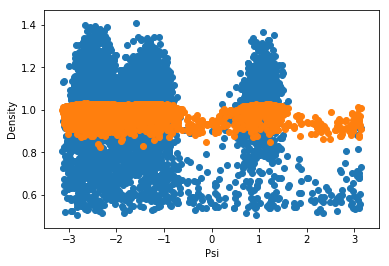

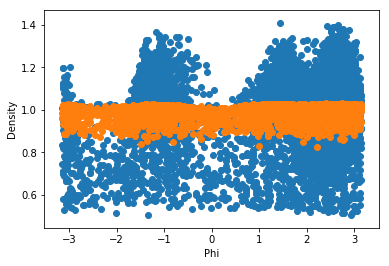

In [33]:
plt.scatter(np.vstack(Y)[:,0], qEmp_FT/np.mean(qEmp_FT))
plt.scatter(np.vstack(Y)[:,0], qTarget_FT/np.mean(qTarget_FT))
plt.xlabel('Psi')
plt.ylabel('Density')

plt.show()

plt.scatter(np.vstack(Y)[:,1], qEmp_FT/np.mean(qEmp_FT))
plt.scatter(np.vstack(Y)[:,1], qTarget_FT/np.mean(qTarget_FT))
plt.xlabel('Phi')
plt.ylabel('Density')

plt.show()

In [34]:
def histogramFreeEnergy(angles, weights = weight):
    

    nrbins=200
    FplotPhi=np.zeros(( nrbins))
    FplotPsi=np.zeros(( nrbins))


    Y=angles
    minx=np.min(Y[:,0])
    maxx=np.max(Y[:,0])
    miny=np.min(Y[:,1])
    maxy=np.max(Y[:,1])


    xd=np.linspace(minx, maxx, num=nrbins)
    yd=np.linspace(miny, maxy, num=nrbins)
    
    if weights == None:
        H,x,y = np.histogram2d(Y[:,0], Y[:,1], bins=nrbins, weights=None, normed=True)
    else:
        H,x,y = np.histogram2d(Y[:,0], Y[:,1], bins=nrbins, weights=weight, normed=True)

    H += 0.001
    # compute free energies
    F = -np.log(H)

    # contour plot
    extent = [x[0], x[-1], y[0], y[-1]]
    xticks(np.arange(int(minx), int(maxx)+1, 1))
    yticks(np.arange(int(miny), int(maxy)+1, 2))
    plt.contourf(F.T, 50, cmap=plt.cm.spectral, extent=extent)
    cbar=colorbar()
    cbar.set_label('Free Energy [kJ]')
    xlabel(r'$\Phi$ Angle [radians]')
    xlim(-pi, pi)
    ylabel(r'$\Psi$ Angle [radians]')
    ylim(-pi, pi)
    if weights == None:
        plt.title('Raw')
    else:
        plt.title('Weights')
    plt.show()

    # Hplot=np.copy(H)-0.1
    # for ih in range(Hplot.shape[0]):
    #     for jh in range(Hplot.shape[0]):
    #         if Hplot[ih,jh]==0:
    #             Hplot[ih,jh]==1.0

    # Fplot = -np.log(Hplot)
    FplotPhi=-np.log(np.mean(H, axis=1) )#np.mean(F, axis=1)
    FplotPsi=-np.log(np.mean(H, axis=0) )
    
    return FplotPhi, FplotPsi, xd

Populating the interactive namespace from numpy and matplotlib


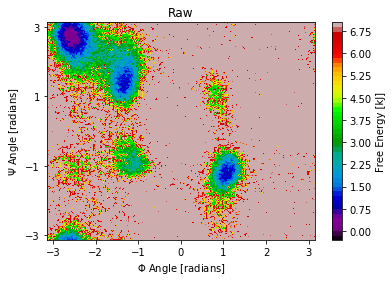

/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/zofia/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


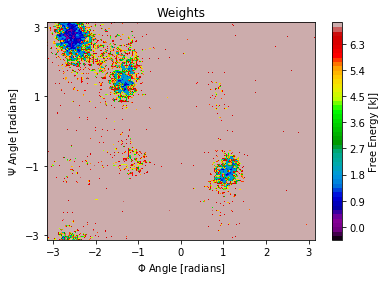

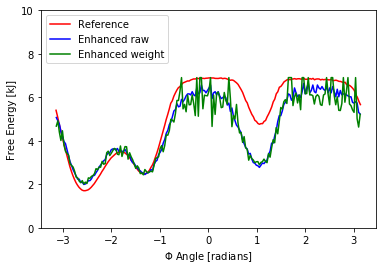

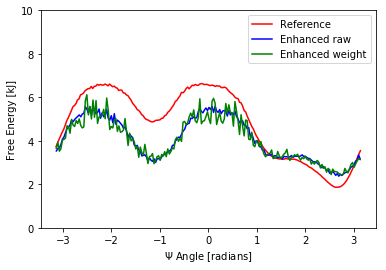

In [45]:
%pylab inline

#################

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
            
inp=md.Trajectory(X_FT, top)

angles_raw = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 
     
###################

# reference values
weightNormed=weight/np.sum(weight)

FplotPhi_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Phi_reference300K.npy')
FplotPsi_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Psi_reference300K.npy')
xd_ref = np.load('/Users/zofia/github/DFM/Data/Alanine/T300/Std/FreeEnergy_Grid_reference300K.npy')


###
FplotPhi, FplotPsi, xd = histogramFreeEnergy(angles_raw, weights = None)
FplotPhi_weight, FplotPsi_weight, xd = histogramFreeEnergy(angles, weights = weightNormed)
               
###############################

plt.plot(xd_ref, FplotPhi_ref,  c='r')
plt.plot(xd, FplotPhi,  c='b')
plt.plot(xd, FplotPhi_weight,  c='g')
    
minY=0
maxY=10
plt.xlabel(r'$\Phi$ Angle [radians]')
plt.ylabel(r'Free Energy [kJ]')
plt.ylim(minY, maxY)
plt.legend(['Reference','Enhanced raw', 'Enhanced weight'], bbox_to_anchor=(0, 1), loc=2, borderaxespad=0.5)
plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergyAnglePhi_comparison.png', dpi='figure', bbox_inches='tight')
plt.show()

###############################
plt.plot(xd_ref, FplotPsi_ref, c='r')
plt.plot(xd, FplotPsi, c='b')
plt.plot(xd, FplotPsi_weight, c='g')

plt.xlabel(r'$\Psi$ Angle [radians]')
plt.ylabel(r'Free Energy [kJ]')
plt.legend(['Reference','Enhanced raw', 'Enhanced weight'], bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.5) 
plt.ylim(minY, maxY)


#plt.scatter(-1500*V1_FT, freeEnergy, s=5);

#plt.savefig('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/freeEnergyAnglePsi_comparison.png', dpi='figure', bbox_inches='tight')


plt.show()

 
np.save('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/FreeEnergy_Phi', FplotPhi)
np.save('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/FreeEnergy_Psi', FplotPsi)
np.save('/Users/zofia/github/DFM/Data/Alanine/'+methodName+'/FreeEnergy_Grid', xd)






In [36]:
#---------- VISUALISATION OF THE MOLECULE
#align according to first frame

traj=traj_FT
traj[0]=traj[0].superpose(traj[0][0])
tpl=traj[0].topology
print(tpl)
import nglview as nv
view = nv.show_mdtraj(traj[0])

#view.add_representation('spacefill', selection='all' )
#view.add_representation('cartoon', selection='protein', color='blue')
view.add_representation('licorice', selection='all', color='red')
#view.frame = 10
view

#--- saving as gif: does not work :(
# from nglview.contrib.movie import MovieMaker
# movie = MovieMaker(view, output='my.gif')
# movie.make()


<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds>


A Jupyter Widget

In [37]:

psi_indices, phi_indices = [6, 8, 14, 16], [4, 6, 8, 14]
top=md.Topology().from_openmm(samplerAlgo.model.testsystem.topology)
    
            
inp=md.Trajectory(X_FT, top)
   
angles = md.geometry.compute_dihedrals(inp, [phi_indices, psi_indices]) 

for i in range(len(X_FT)):
    if angles[i,0]>0.7 and angles[i,0]<1.5  and angles[i,1]<0.5 and angles[i,1]-2.0:
        print(i)
        break

7345


In [ ]:
print(7345*10*2)

In [ ]:
print(2.64/0.14)